In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

# Multiple Categories

Whether jury panels are representative of the eligible population continues to be an important question. We will address it in the context of more recent panels than that of Robert Swain in the 1960s.

The general process of assessment will be the same as before. But this time we will consider panelists in multiple racial and ethnic categories, not just two. From a technical perspective, this will mean that we have to come up with a new statistic to simulate. Once we have simulated it and arrived at a conclusion, we will examine some of the underlying causes of the discrepancies that we observe.

## Jury Selection in Alameda County

In 2010, the American Civil Liberties Union (ACLU) of Northern California presented a [report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf "ACLU_NC report") on jury selection in Alameda County, California. The report concluded that certain racial and ethnic groups are underrepresented among jury panelists in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. In this section, we will analyze the data provided by the ACLU.

As you saw in the previous section, trial jurors are selected from a larger jury panel. By law, the jury panel is supposed to be representative of the population of eligible jurors. In California, the word "representative" is clearly defined as "selected at random." Section 197 of California's Code of Civil Procedure says, "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

Here "selected for jury service" means being selected to be on the jury panel.

## Composition of Panels in Alameda County

The focus of the study by the ACLU of Northern California was the racial and ethnic composition of jury panels in Alameda County. The ACLU compiled data on the composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010. In those panels, the total number of people who reported for jury service was 1453. The ACLU gathered demographic data on all of these prosepctive jurors, and compared those data with the composition of all eligible jurors in the county. 

The data are tabulated below in a table called ``jury``. In each category, the first numerical value is the proportion of all eligible juror candidates in that category. The second value is the proportion of people in that category among those who appeared for the process of selection into the jury.

The labels for the different categories are taken from the ACLU report, which says, "The category “other” includes people who identified as mixed race without identifying one primary racial identity, and individuals who did not identify a race or ethnicity." The label `Asian/PI` means "Asian or Pacific Islander." The label `Black/AA` means "Black or African-American."

In [2]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian/PI', 'Black/AA', 'Caucasian', 'Hispanic', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.54, 0.12, 0.01),
    'Panels', make_array(0.26, 0.08, 0.54, 0.08, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian/PI,0.15,0.26
Black/AA,0.18,0.08
Caucasian,0.54,0.54
Hispanic,0.12,0.08
Other,0.01,0.04


Some ethnicities are overrepresented and some are underrepresented on the jury panels in the study. In particular, panelists in the Black/AA and Hispanic categories are underrepresented. 

A bar chart is helpful for visualizing the differences.

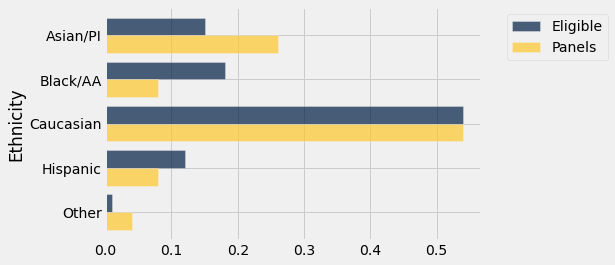

In [3]:
jury.barh('Ethnicity')

## Comparison with Panels Selected at Random
What if we select a random sample of 1,453 people from the population of eligible jurors? Will the distribution of their ethnicities look like the distribution of the panels above?

We can answer these questions by using `sample_proportions` and augmenting the `jury` table with a column of the proportions in our sample.

**Technical note.** Random samples of prospective jurors would be selected without replacement. However, when the size of a sample is small relative to the size of the population, sampling without replacement resembles sampling with replacement; the proportions in the population don't change much between draws. The population of eligible jurors in Alameda County is over a million, and compared to that, a sample size of about 1500 is quite small. We will therefore sample with replacement.

In the cell below, we sample at random 1453 times from the distribution of eligible jurors, and display the distribution of the random sample along with the distributions of the eligible jurors and the panel in the data.

In [4]:
eligible_population = jury.column('Eligible')
sample_distribution = sample_proportions(1453, eligible_population)
panels_and_sample = jury.with_column('Random Sample', sample_distribution)
panels_and_sample

Ethnicity,Eligible,Panels,Random Sample
Asian/PI,0.15,0.26,0.14384
Black/AA,0.18,0.08,0.163799
Caucasian,0.54,0.54,0.538197
Hispanic,0.12,0.08,0.143152
Other,0.01,0.04,0.0110117


The distribution of the random sample is quite close to the distribution of the eligible population, unlike the distribution of the panels. As always, it helps to visualize.

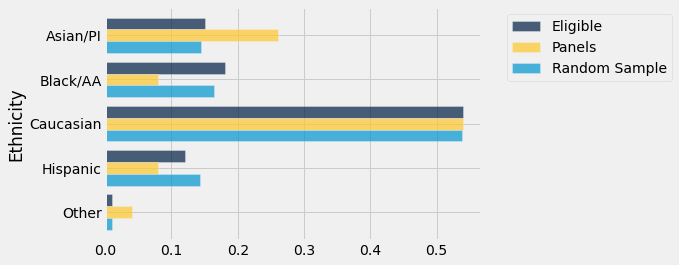

In [5]:
panels_and_sample.barh('Ethnicity')

The bar chart shows that the distribution of the random sample resembles the eligible population but the distribution of the panels does not.

To assess whether this observation is particular to one random sample or more general, we can  simulate multiple panels under the model of random selection and see what the simulations predict. But we won't be able to look at thousands of bar charts like the one above. We need a statistic that will help us assess whether or not the model or random selection is supported by the data.

## A New Statistic: The Distance between Two Distributions
We know how to measure how different two numbers are: if the numbers are $x$ and $y$, the distance between them is $\vert x-y \vert$. Now we have to quantify the distance between two distributions. For example, we have to measure the distance between the blue and gold distributions below.

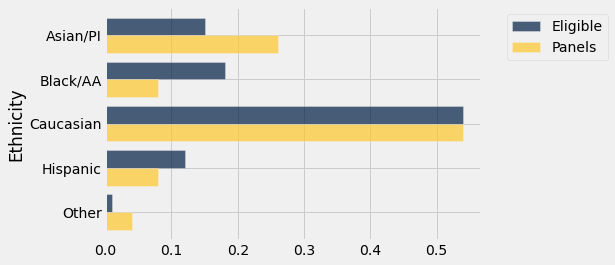

In [6]:
jury.barh('Ethnicity')

For this we will compute a quantity called the *total variation distance* between two distributions. The calculation is as an extension of how we find the distance between two numbers.

To compute the total variation distance, we first find the difference between the two proportions in each category.

In [7]:
# Augment the table with a column of differences between proportions

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)
jury_with_diffs

Ethnicity,Eligible,Panels,Difference
Asian/PI,0.15,0.26,0.11
Black/AA,0.18,0.08,-0.1
Caucasian,0.54,0.54,0
Hispanic,0.12,0.08,-0.04
Other,0.01,0.04,0.03


Take a look at the column `Difference` and notice that the sum of its entries is 0: the positive entries add up to 0.14, exactly canceling the total of the negative entries which is -0.14. 

This is numerical evidence of the fact that in the bar chart, the gold bars exceed the blue bars by exactly as much as the blue bars exceed the gold. The proportions in each of the two columns ``Panels`` and ``Eligible`` add up to 1, and so the give-and-take between their entries must add up to 0. 

To avoid the cancellation, we drop the negative signs and then add all the entries. But this gives us two times the total of the positive entries (equivalently, two times the total of the negative entries, with the sign removed). We don't need that doubling, so we divide the sum by 2.

In [8]:
jury_with_diffs = jury_with_diffs.with_column(
    'Absolute Difference', np.abs(jury_with_diffs.column('Difference'))
)

jury_with_diffs

Ethnicity,Eligible,Panels,Difference,Absolute Difference
Asian/PI,0.15,0.26,0.11,0.11
Black/AA,0.18,0.08,-0.1,0.1
Caucasian,0.54,0.54,0,0
Hispanic,0.12,0.08,-0.04,0.04
Other,0.01,0.04,0.03,0.03


In [9]:
jury_with_diffs.column('Absolute Difference').sum() / 2

0.14

This quantity 0.14 is the *total variation distance* (TVD) between the distribution of ethnicities in the eligible juror population and the distribution in the panels.

In general, the total variation distance between two distributions measures how close the distributions are. The larger the TVD, the more different the two distributions appear.

**Technical Note:** We could have obtained the same result by just adding the positive differences. But our method of including all the absolute differences eliminates the need to keep track of which differences are positive and which are not.

We will use the total variation distance between distributions as the statistic to simulate under the assumption of random selection. Large values of the distance will be evidence against random selection.

## Simulating the Statistic Under the Model
To see how the TVD varies across random samples, we will simulate it repeatedly under the model of random selection from the eligible population.

Let's organize our calculation. Since we are going to be computing total variation distance repeatedly, we will first write a function that computes it for two given distributions.

The function `total_variation_distance` takes two arrays containing the distributions to compare, and returns the TVD between them.

In [10]:
def total_variation_distance(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2

This function will help us calculate our statistic in each repetition of the simulation. But first let's check that it gives the right answer when we use it to compute the distance between the blue (eligible) and gold (panels) distributions above. These are the distribution in the ACLU study.

In [11]:
total_variation_distance(jury.column('Panels'), jury.column('Eligible'))

0.14

This agrees with the value that we computed directly without using the function.

In the cell below we use the function to compute the TVD between the distributions of the eligible jurors and one random sample. Recall that `eligible_population` is the array containing the distribution of the eligible jurors, and that our sample size is 1453.

In the first line, we use `sample_proportions` to generate a random sample from the eligible population. In the next line we use `total_variation_distance` to compute the TVD between the distributions in the random sample and the eligible population.

In [20]:
sample_distribution = sample_proportions(1453, eligible_population)
total_variation_distance(sample_distribution, eligible_population)

0.018265657260839632

Run the cell a few times and notice that the distances are quite a bit smaller than 0.14, the distance between the distribution of the panels and the eligible jurors.

We are now ready to run a simulation to assess the model of random selection.

### Simulating One Value of the Statistic
In the same way that we start every simulation, let's define a function `one_simulated_tvd` that returns one simulated value of the total variation distance under the hypothesis of random selection. 

The code in the body of the definition is based on the cell above.

In [13]:
# Simulate one simulated value of 
# the total variation distance between
# the distribution of a sample selected at random
# and the distribution of the eligible population

def one_simulated_tvd():
    sample_distribution = sample_proportions(1453, eligible_population)
    return total_variation_distance(sample_distribution, eligible_population)   

### Simulating Multiple Values of the Statistic
Now we can apply the familiar process of using a `for` loop to create an array consisting of 5000 such distances.

In [14]:
tvds = make_array()
repetitions = 5000
for i in np.arange(repetitions):
    tvds = np.append(tvds, one_simulated_tvd())

## Assessing the Model of Random Selection

Here is the empirical histogram of the simulated distances. It shows that if you draw 1453 panelists at random from the pool of eligible candidates, then the distance between the distributions of the panelists and the eligible population is rarely more than about 0.05.

The panels in the study, however, were not quite so similar to the eligible population. The total variation distance between the panels and the population was 0.14, shown as the red dot on the horizontal axis. It is far beyond the tail of the histogram and does not look at all like a typical distance between the distributions of a random sample and the eligible population.

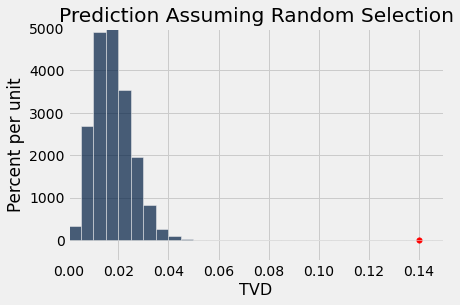

In [15]:
Table().with_column('TVD', tvds).hist(bins=np.arange(0, 0.2, 0.005))

# Plotting parameters; you can ignore this code
plots.title('Prediction Assuming Random Selection')
plots.xlim(0, 0.15)
plots.ylim(-5, 50)
plots.scatter(0.14, 0, color='red', s=30);

The simulation shows that the composition of the panels in the ACLU study is not consistent with the model of random selection. Our analysis supports the ACLU's conclusion that the panels were not representative of the distribution provided for the eligible jurors. 

## Reasons for the Bias
As with most such analyses, ours doesn't say *why* the distributions are different. But those reasons are important to understand. If jury panels don't represent the population of eligible jurors, that can have a major effect on due process and the fairness of jury trials.

The ACLU report discusses several possible reasons for the discrepancies and suggests some remedies. Some are purely practical but have a big impact. For example, while we can take for granted the high quality of random sampling in Python, the panel selection used other software. The ACLU's examination revealed that the software didn't work well, contributing to biased selection. Using better software is a clear remedy.

More significantly, Alameda County jury panels are not selected from the entire eligible population. The [website](http://www.alameda.courts.ca.gov/pages.aspx/faqs) of the Superior Court of Alameda County says, "The objective of the court is to provide an accurate cross-section of the county's population. The names of jurors are selected at random from everyone who is a registered voter and/or has a driver's license or identification card issued by the Department of Motor Vehicles."

This process excludes eligible jurors who are not on those lists. Having state-issued ID or being registered to vote is most likely associated with income and hence also with race and ethnicity due to historical bias against Black and Hispanic communities. This leads to underrepresentation of those groups on the panels.

Those on the list have to be reached in order to inform them of their jury summons. But people in under-resourced communities don't always have fixed addresses. Out-of-date address records, lack of cross-checking with other lists such as those of the utilities, and so on can all contribute to biased selection.

Once reached, the potential panelists still have to be able to appear. The first day of jury service is not compensated, and compensation for subsequent days is \$15 per day. While employers are required by law to excuse employees who have jury duty, they are not required to provide compensation, and some employers don't. In a region as expensive as the Bay Area, this can become a reason for panelists not to respond to jury summons. Though jurors can be excused for severe economic hardship, even the process of requesting to be excused can be out of reach for some jurors. Across the Bay, city leaders in San Francisco are attempting to reduce this form of bias by piloting a [program](https://sftreasurer.org/new-ca-bill-pilots-higher-compensation-low-income-jurors-san-francisco) that provides compensation of \$100 per day to low-income jurors. 

## Data Quality
We have developed a technique that helps us decide whether one distribution looks like a random sample from another. But we should examine our data sources to better understand exactly what we can conclude from our analysis. Good data science includes a thoughtful examination of how the data were gathered. 

**Eligible Jurors.** It is important to keep in mind that not everyone is eligible to serve on a jury. On its [website](http://www.alameda.courts.ca.gov/pages.aspx/jury-duty-overview), the Superior Court of Alameda County says, "You may be called to serve if you are 18 years old, a U.S. citizen and a resident of the county or district where summoned. You must be able to understand English, and be physically and mentally capable of serving. In addition, you must not have served as any kind of juror in the past 12 months, nor have been convicted of a felony."

Though the Census is a natural source of demographic information, the Census doesn't collect data on all these categories. Thus the ACLU had to obtain the demographics of eligible jurors in some other way. 

What they used was a set of estimates that had been developed by a San Diego State University professor for an Alameda County trial in 2002. Those estimates were based on the 2000 Census and also took into account the criteria required for eligibility as a juror.

So we have to keep in mind that the distribution that we used for the eligible population is itself an estimate and is therefore subject to error. Moreover, as the ACLU noted, using estimates based on the 2000 Census for populations in 2010 might not be accurate due to the changing demographics in California.

Thus the distribution used for the population of eligible jurors might not be accurate.

**Panels.** It is not clear from the report exactly how the 1453 panelists were classified into the different ethnic categories. The report says only that "attorneys ... cooperated in collecting jury pool data". 

Significant social, cultural, and political factors affect who gets classified or self-classifies into each ethnic category. It is also not clear if the definitions of those categories in the panels were the same as those used in the estimates of the distribution of eligible jurors. This raises questions about the correspondence between the two distributions being compared.

Moreover, the data on panelists was obtained from those who reported for service. As we have discussed, not all panelists do so. The reasons for not reporting are associated with race and ethnicity, and disproportionately affect panelists from under-resourced communities. 

Responding to jury summons is required by law. But as the ACLU noted, at the time of the study Alameda County did not have an effective process for following up on prospective jurors who had been called but had failed to appear. The ACLU recommended the creation of "a failure to appear program that requires, at a minimum, the issuance of a second notice to prospective jurors." 

Indeed, following up on non-respondents would reduce bias. For our analysis, we must acknowledge that we don't have the data needed to fill in the demographic information for panelists who were selected but did not report for service.

## Conclusion

Because of the discussion above, it is important for us to be precise about what we can conclude from our analysis.

- We can conclude that the distribution provided for the panelists who reported for service does not look like a random sample from the estimated distribution in the eligible population.

Our discussion, like the discussion in the ACLU report, sets out reasons for some of the differences observed between the two distributions and for why summoned panelists might nor report. Almost all the reasons have their roots in historical racial bias in society, and are examples of the lasting negative consequences of that bias.